<a href="https://colab.research.google.com/github/Viny2030/Algoritmos_en_produccion/blob/main/credit_fraud_dealing_with_imbalanced_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Detector de Fraude en Créditos </h1>

<h2> Introducción </h2>
En este notebook vamos a usar varios modelos predictivos para ver qué tan precisos son al detectar si una transacción es un pago normal o un fraude. Tal como se describe en el conjunto de datos, las variables están normalizadas y sus nombres no son visibles por razones de privacidad. Sin embargo, aún podemos analizar algunos aspectos importantes del dataset. ¡Vamos a empezar!


<h2> Nuestros Objetivos: </h2>
<ul>
<li> Comprender la distribución de los pocos datos que se nos proporcionaron. </li>
<li> Crear un sub-dataframe con una proporción 50/50 de transacciones "Fraudulentas" y "No Fraudulentas". </li>
<li> Determinar los clasificadores que vamos a utilizar y decidir cuál tiene mayor precisión. </li>
<li>Comprender errores comunes al trabajar con conjuntos de datos desbalanceados. </li>
</ul>


## Obtener una Idea General de Nuestros Datos:
<a id="gather"></a>
Lo primero que debemos hacer es obtener una <b> idea básica </b> de nuestros datos. Recordá que, excepto por las columnas <b>transaction</b> y <b>amount</b>, no sabemos qué representan las otras columnas (por razones de privacidad). Lo único que sabemos es que esas columnas desconocidas ya han sido escaladas.   


<h3> Aspectos Técnicos de las Variables: </h3>
<ul>
<li> <b>Transformación PCA:</b> La descripción del dataset indica que todas las variables pasaron por una transformación PCA (<b>Principal Component Analysis</b> , técnica de reducción de dimensionalidad), excepto las columnas de tiempo y monto.</li>
<li> <b>Escalado:</b> Tené en cuenta que para aplicar una transformación PCA, las variables deben estar previamente escaladas. (En este caso, todas las variables V han sido escaladas, o al menos eso es lo que asumimos que hicieron las personas que desarrollaron el dataset).</li>
</ul>


In [1]:
# Este entorno de Python 3 ya viene con muchas librerías útiles para análisis instaladas
# Por ejemplo, acá cargamos varios paquetes útiles

# Librerías importadas

import numpy as np  # álgebra lineal
import pandas as pd  # procesamiento de datos, lectura de archivos CSV, etc.
import tensorflow as tf
import matplotlib.pyplot as plt  # para visualizaciones
import seaborn as sns  # visualizaciones estadísticas
from sklearn.manifold import TSNE  # reducción de dimensionalidad (t-SNE)
from sklearn.decomposition import PCA, TruncatedSVD  # reducción de dimensionalidad
import matplotlib.patches as mpatches  # para leyendas personalizadas en gráficos
import time  # para medir tiempos de ejecución

# Librerías de clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections  # estructuras como Counter

# Otras librerías
from sklearn.model_selection import train_test_split  # para dividir en conjunto de entrenamiento/test
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline  # versión compatible con datasets desbalanceados
from imblearn.over_sampling import SMOTE  # técnica de oversampling
from imblearn.under_sampling import NearMiss  # técnica de undersampling
from imblearn.metrics import classification_report_imbalanced  # métricas específicas para datos desbalanceados
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold  # validación cruzada
import warnings
warnings.filterwarnings("ignore")  # ignorar advertencias para mantener limpio el output

# Descarga del dataset desde Google Drive
!gdown https://drive.google.com/uc?id=1H1_9VXGg8QhkiLExs09_s_flCF_QCKPc

# Lectura del archivo CSV
df = pd.read_csv('creditcard.csv')
df.head()  # mostrar las primeras filas del dataframe


Downloading...
From (original): https://drive.google.com/uc?id=1H1_9VXGg8QhkiLExs09_s_flCF_QCKPc
From (redirected): https://drive.google.com/uc?id=1H1_9VXGg8QhkiLExs09_s_flCF_QCKPc&confirm=t&uuid=cac2e926-a95d-4604-8566-858dc1d8faf8
To: /content/creditcard.csv
100% 151M/151M [00:01<00:00, 88.0MB/s]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
# ¡Bien! No hay valores nulos
df.isnull().sum().max()


0

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# Las clases están fuertemente desbalanceadas; vamos a tener que resolver este problema más adelante.
print('Transacciones no fraudulentas:', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% del dataset')
print('Transacciones fraudulentas:', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% del dataset')


Transacciones no fraudulentas: 99.83 % del dataset
Transacciones fraudulentas: 0.17 % del dataset


<h3> Resumen: </h3>
<ul>
<li>El monto de las transacciones es relativamente <b>bajo</b>. El promedio de todos los montos es aproximadamente USD 88. </li>
<li>No hay valores <b>"Null"</b>, así que no tenemos que preocuparnos por reemplazar valores faltantes. </li>
<li> La mayoría de las transacciones fueron <b>No Fraudulentas</b> (99.83% del tiempo), mientras que las transacciones <b>Fraudulentas</b> ocurrieron el 0.17% del tiempo en el dataframe. </li>
</ul>


**Nota:** ¡Notá cuán desbalanceado está nuestro dataset original! La mayoría de las transacciones no son fraudulentas. Si usamos este dataframe como base para nuestros modelos predictivos y análisis, podríamos cometer muchos errores y nuestros algoritmos probablemente sufran de *overfitting*, ya que "asumirán" que la mayoría de las transacciones no son fraude. ¡Pero no queremos que nuestro modelo asuma nada, queremos que detecte patrones que indiquen señales de fraude!


Text(0.5, 1.0, 'Distribución de Clases \n (0: No Fraude || 1: Fraude)')

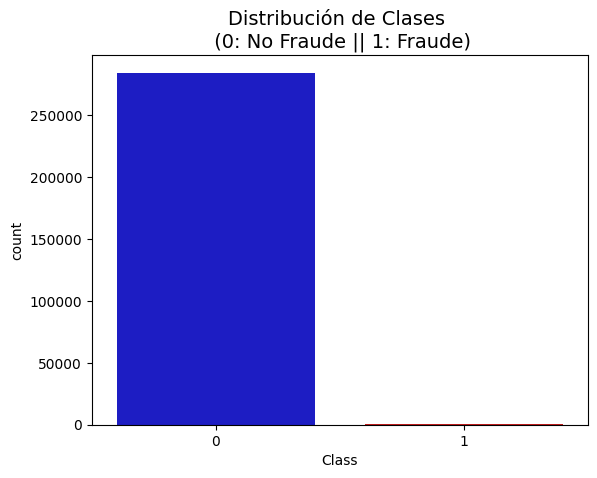

In [6]:
import seaborn as sns
colors = ["#0101DF", "#DF0101"]

# Gráfico de barras para visualizar la distribución de clases
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Distribución de Clases \n (0: No Fraude || 1: Fraude)', fontsize=14)

**Distribuciones:** Al observar las distribuciones podemos darnos una idea de cuán desbalanceadas están estas variables. También podemos analizar las distribuciones del resto de las variables. Existen técnicas que pueden ayudar a que estas distribuciones sean menos sesgadas, y algunas de ellas serán implementadas más adelante en este notebook.


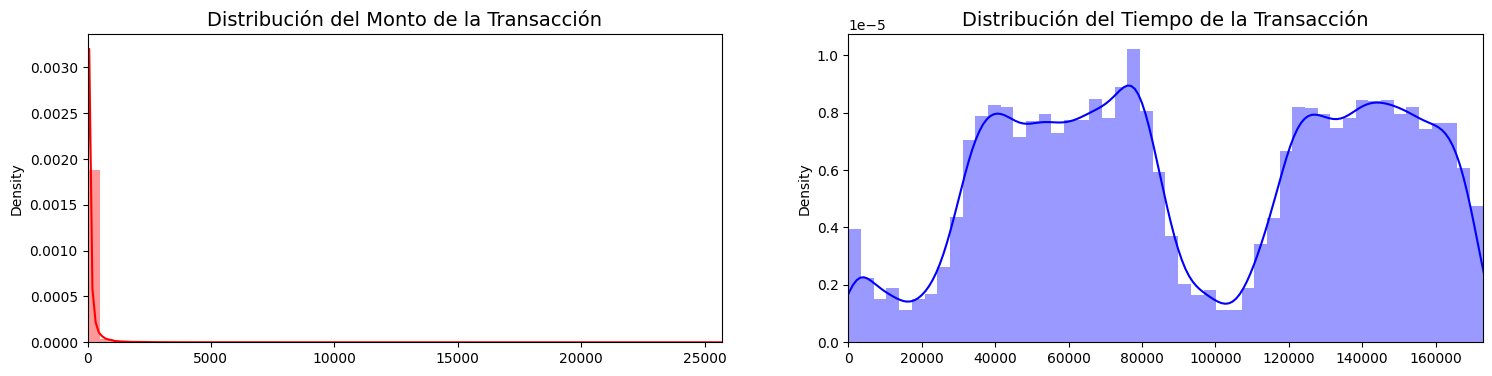

In [7]:
# Visualizamos la distribución de las variables Amount y Time

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribución del Monto de la Transacción', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribución del Tiempo de la Transacción', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()


<h2> Escalado y Distribución </h2>
<a id="distributing"></a>
En esta fase del notebook, primero vamos a escalar las columnas <b>Time</b> y <b>Amount</b>. Estas variables también deben ser escaladas como el resto de las columnas. Por otro lado, también vamos a crear un sub-sample del dataframe con el fin de tener una cantidad igual de casos de fraude y no fraude, lo que ayudará a que nuestros algoritmos comprendan mejor los patrones que determinan si una transacción es fraudulenta o no.

<h3> ¿Qué es un sub-sample?</h3>
En este caso, nuestro sub-sample será un dataframe con una proporción 50/50 de transacciones fraudulentas y no fraudulentas. Es decir, tendrá la misma cantidad de transacciones de cada clase.

<h3> ¿Por qué creamos un sub-sample?</h3>
Al comienzo de este notebook vimos que el dataframe original estaba fuertemente desbalanceado. Usar ese dataframe sin modificar causaría los siguientes problemas:
<ul>
<li><b>Overfitting:</b> Nuestros modelos de clasificación asumirán que en la mayoría de los casos no hay fraude. ¡Pero lo que queremos es que el modelo sea preciso al detectar fraudes!</li>
<li><b>Correlaciones erróneas:</b> Aunque no sabemos qué representan las variables "V", sería útil entender cómo influye cada una en el resultado (Fraude o No Fraude). Si usamos un dataframe desbalanceado, no podremos ver las correlaciones reales entre las variables y la clase.</li>
</ul>

<h3>Resumen: </h3>
<ul>
<li> <b>Amount escalado</b> y <b>Time escalado</b> son las columnas con valores escalados. </li>
<li> Hay <b>492 casos</b> de fraude en nuestro dataset, así que podemos tomar aleatoriamente 492 casos de no fraude para crear nuestro nuevo sub-dataframe. </li>
<li>Concatenamos los 492 casos de fraude y no fraude, <b>creando un nuevo sub-sample.</b></li>
</ul>


In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [10]:
# Como la mayoría de nuestros datos ya fueron escalados, deberíamos escalar las columnas que faltan (Amount y Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler es menos sensible a los valores atípicos (outliers).

std_scaler = StandardScaler()
rob_scaler = RobustScaler()   #### mas robustos a los outliers

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))




In [11]:
# Guardamos las columnas escaladas en variables temporales
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# Eliminamos las columnas escaladas de su posición actual
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

# Insertamos las columnas escaladas al inicio del dataframe (en las posiciones 0 y 1)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# ¡Amount y Time han sido escalados!

df.head()

,scaled_amount,scaled_time,Time,V1,V2,V3,V4,V5,V6,V7,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.783274,-0.994983,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,-0.269825,-0.994983,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,4.983721,-0.994972,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.418291,-0.994972,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.670579,-0.994960,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Separación del Dataset (DataFrame Original)
<a id="splitting"></a>
Antes de proceder con la <b>técnica de Random UnderSampling</b>, tenemos que separar el dataframe original. <b>¿Por qué? Por fines de evaluación. Recordá que, aunque estemos dividiendo los datos al implementar técnicas de Random UnderSampling u OverSampling, queremos evaluar nuestros modelos sobre el conjunto de prueba original, no sobre el conjunto de prueba creado por esas técnicas.</b> El objetivo principal es ajustar (fit) el modelo con los dataframes submuestreados o sobremuestreados (para que el modelo aprenda los patrones) y evaluarlo sobre el conjunto de prueba original.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Eliminamos las columnas originales de Time y Amount (ya están escaladas y recolocadas)
df.drop(['Time','Amount'], axis=1, inplace=True)

print('Transacciones no fraudulentas:', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% del dataset')
print('Transacciones fraudulentas:', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% del dataset')

X = df.drop('Class', axis=1)
y = df['Class']



Transacciones no fraudulentas: 99.83 % del dataset
Transacciones fraudulentas: 0.17 % del dataset


## Submuestreo Aleatorio (Random Under-Sampling):

En esta fase del proyecto vamos a implementar "Random Under-Sampling", que básicamente consiste en eliminar datos para obtener un <b>dataset más balanceado</b> y así evitar que nuestros modelos sufran de overfitting.

#### Pasos:
<ul>
<li>Lo primero que tenemos que hacer es determinar cuán <b>desbalanceada</b> está nuestra clase (usar "value_counts()" sobre la columna de clase para ver la cantidad de instancias de cada etiqueta).</li>
<li>Una vez que determinamos cuántas instancias corresponden a <b>transacciones fraudulentas</b> (Fraud = "1"), deberíamos reducir las <b>transacciones no fraudulentas</b> a la misma cantidad que las fraudulentas (asumiendo que buscamos una proporción 50/50). Esto equivale a 492 casos de fraude y 492 casos de no fraude.</li>
<li>Después de aplicar esta técnica, obtenemos un sub-sample de nuestro dataframe con una proporción 50/50 entre clases. El siguiente paso será <b>mezclar aleatoriamente los datos</b> (shuffle) para ver si nuestros modelos pueden mantener cierta precisión cada vez que ejecutamos este script.</li>
</ul>

**Nota:** El principal problema del *Random Under-Sampling* es que corremos el riesgo de que nuestros modelos de clasificación no rindan tan bien como nos gustaría, ya que hay una importante <b>pérdida de información</b> (reducimos de 284.315 transacciones no fraudulentas a solo 492).


In [13]:
# Como nuestras clases están fuertemente desbalanceadas, deberíamos igualarlas para obtener una distribución más equilibrada.

# Mezclamos aleatoriamente los datos antes de crear los sub-samples
df = df.sample(frac=1)

# Cantidad de transacciones fraudulentas: 492 filas
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

# Combinamos ambas clases para obtener un dataset balanceado
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Mezclamos nuevamente las filas del nuevo dataframe balanceado
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
269269,-0.204150,0.927173,2.036425,-0.108150,-3.181812,-0.606965,2.690173,3.009492,-0.377096,0.724118,...,-0.121790,0.195392,0.610155,0.015815,0.637030,0.287956,-0.080919,0.015884,-0.037093,0
42528,4.445050,-0.511684,-4.595617,5.083690,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.714670,...,1.682160,2.248971,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,1
17409,1.319779,-0.657891,-0.124785,-0.777998,1.700077,-1.271554,-0.922643,0.621544,0.016505,-0.076524,...,-0.180708,-0.207211,0.336673,0.182778,-0.364392,-1.038058,0.889240,0.034801,0.010763,0
44223,1.647453,-0.503307,-19.139733,9.286847,-20.134992,7.818673,-15.652208,-1.668348,-21.340478,0.641900,...,0.427203,-2.182692,0.520543,-0.760556,0.662767,-0.948454,0.121796,-3.381843,-1.256524,1
243547,0.499266,0.790423,-6.618211,3.835943,-6.316453,1.844111,-2.476892,-1.886718,-3.817495,0.613470,...,-0.953827,1.636622,0.038727,0.278218,0.786670,0.063895,0.154707,-2.042403,1.405141,1


## Distribución Equitativa y Correlación:
<a id="correlating"></a>
Ahora que tenemos nuestro dataframe correctamente balanceado, podemos avanzar con nuestro <b>análisis</b> y <b>preprocesamiento de datos</b>.


Distribución de las clases en el dataset balanceado
Class
0    0.5
1    0.5
Name: count, dtype: float64


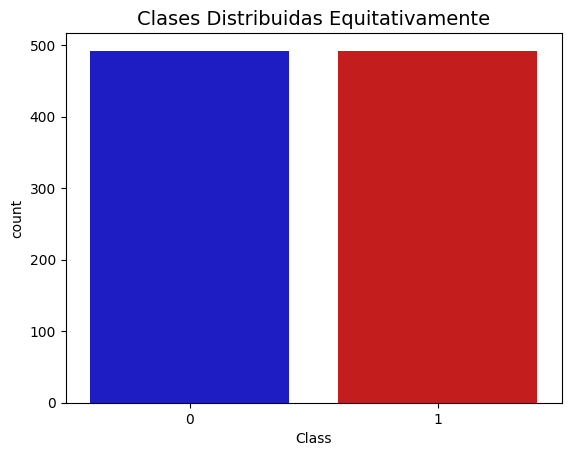

In [14]:
print('Distribución de las clases en el dataset balanceado')
print(new_df['Class'].value_counts() / len(new_df))

# Gráfico de barras para visualizar la distribución balanceada de clases
sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Clases Distribuidas Equitativamente', fontsize=14)
plt.show()


<h3> Matrices de Correlación </h3>
Las matrices de correlación son fundamentales para comprender nuestros datos. Queremos saber si hay variables que influyen fuertemente en que una transacción específica sea un fraude. Sin embargo, es importante que usemos el dataframe correcto (el sub-sample) para poder ver qué variables tienen una alta correlación positiva o negativa con respecto a las transacciones fraudulentas.



**Nota:** Tenemos que asegurarnos de usar el sub-sample en nuestra matriz de correlación, de lo contrario, la matriz se verá afectada por el fuerte desbalance de clases del dataframe original. Esto se debe al alto desbalance entre clases en los datos originales.


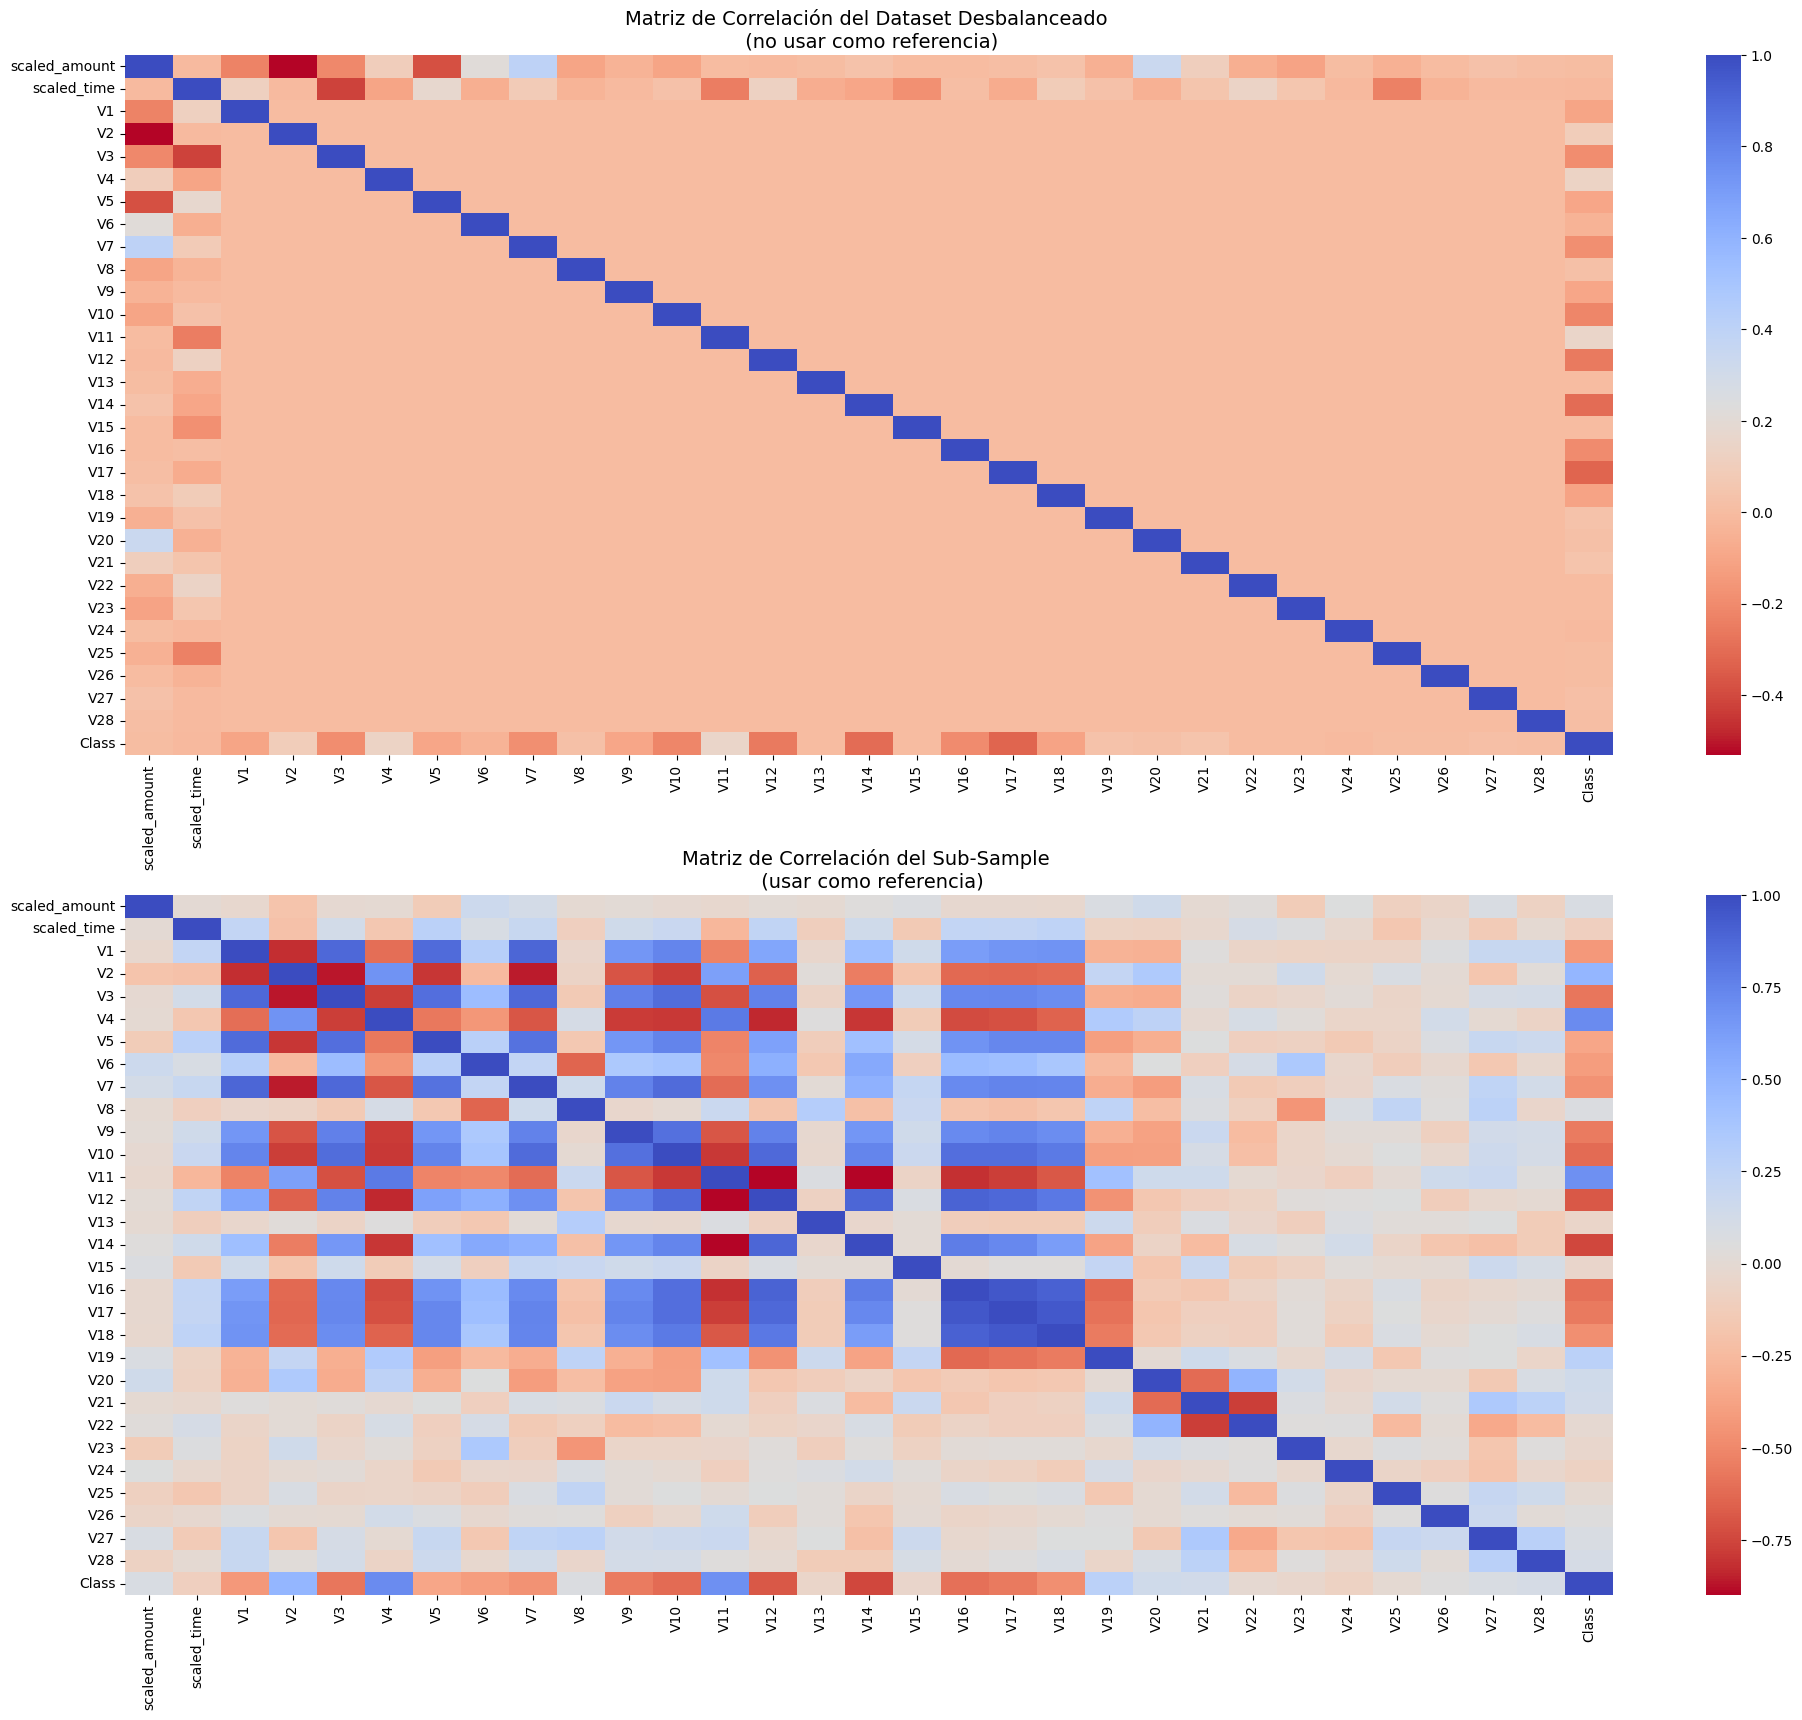

In [15]:
# Asegurarnos de usar el sub-sample en nuestra matriz de correlación

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# DataFrame completo (desbalanceado)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matriz de Correlación del Dataset Desbalanceado \n (no usar como referencia)", fontsize=14)

# Sub-sample balanceado
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Matriz de Correlación del Sub-Sample \n (usar como referencia)', fontsize=14)
plt.show()


### Resumen y Explicación:
<ul>
<li><b>Correlaciones Negativas:</b> V17, V14, V12 y V10 están negativamente correlacionadas. Notá cómo, a menor valor de estas variables, es más probable que el resultado sea una transacción fraudulenta. </li>
<li><b>Correlaciones Positivas:</b> V2, V4, V11 y V19 están positivamente correlacionadas. Notá cómo, a mayor valor de estas variables, es más probable que el resultado sea una transacción fraudulenta. </li>
<li><b>Boxplots:</b> Vamos a utilizar boxplots para entender mejor la distribución de estas variables en las transacciones fraudulentas y no fraudulentas. </li>
</ul>

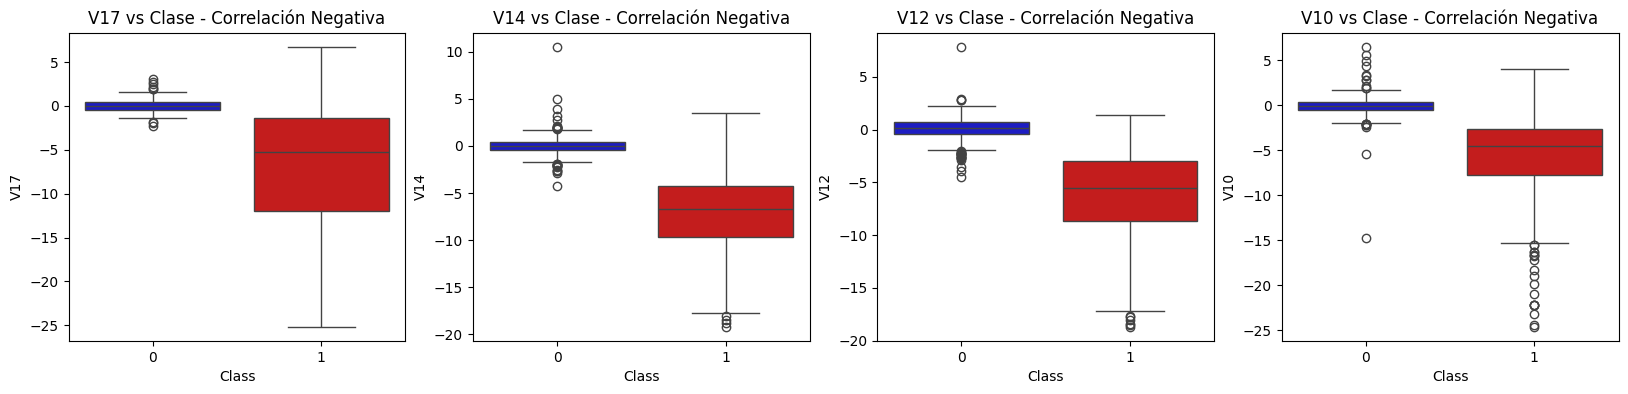

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Correlaciones negativas con la clase (cuanto menor es el valor de la variable, más probable es que sea una transacción fraudulenta)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Clase - Correlación Negativa')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Clase - Correlación Negativa')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Clase - Correlación Negativa')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Clase - Correlación Negativa')

plt.show()


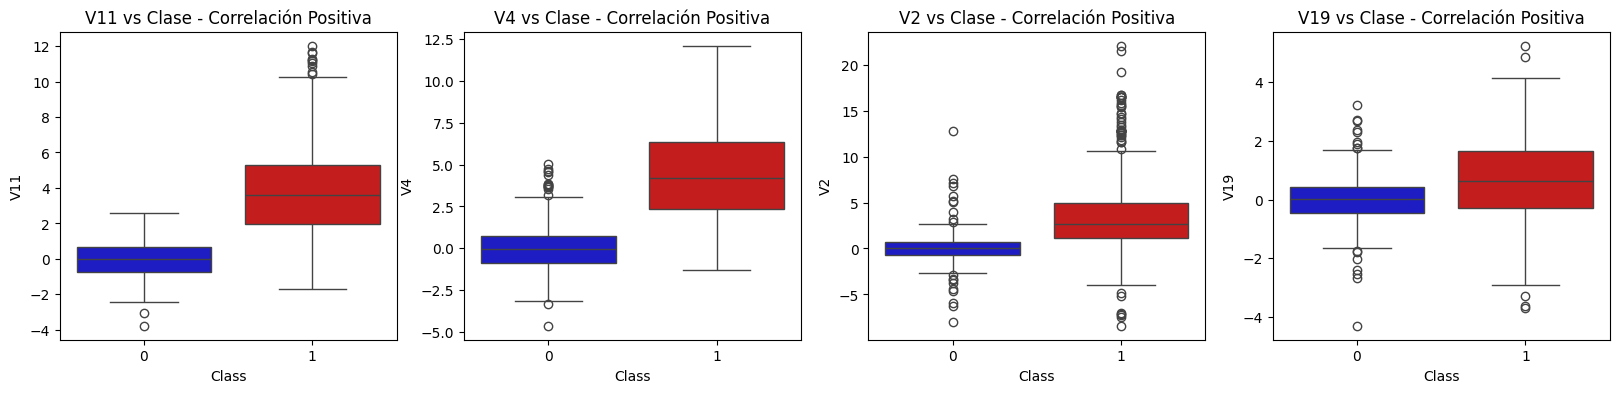

In [17]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Correlaciones positivas (cuanto mayor es el valor de la variable, más probable es que sea una transacción fraudulenta)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Clase - Correlación Positiva')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Clase - Correlación Positiva')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Clase - Correlación Positiva')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Clase - Correlación Positiva')

plt.show()


## Detección de Anomalías:

Nuestro objetivo principal en esta sección es eliminar los "outliers extremos" de aquellas variables que tienen una alta correlación con nuestras clases. Esto tendrá un impacto positivo en la precisión (*accuracy*) de nuestros modelos.  <br><br>

### Método del Rango Intercuartílico (Interquartile Range):
<ul>
<li><b>Rango Intercuartílico (IQR - Interquartile Range):</b> Lo calculamos como la diferencia entre el percentil 75 y el percentil 25. El objetivo es crear un umbral por encima del 75 y por debajo del 25 que, en caso de que una instancia lo supere, sea eliminada. </li>
<li><b>Boxplots:</b> Además de permitir ver fácilmente los percentiles 25 y 75 (los extremos del rectángulo), también permiten identificar outliers extremos (puntos fuera de los bigotes inferior y superior).</li>
</ul>

### Compromiso al Eliminar Outliers:
Hay que tener cuidado con qué tan estricto queremos que sea el umbral para eliminar outliers. Este umbral se determina multiplicando un número (ej: 1.5) por el IQR. Cuanto mayor sea este número (ej: 3), menos outliers se detectarán; cuanto menor (ej: 1), más outliers se eliminarán.  <br><br>

**El compromiso (tradeoff):**  
Cuanto menor el umbral, más outliers se eliminarán. Sin embargo, nos interesa centrarnos en los "outliers extremos" y no en todos los outliers. ¿Por qué? Porque corremos el riesgo de perder información valiosa, lo cual podría hacer que nuestro modelo tenga menor precisión. Podés experimentar modificando este umbral y observar cómo afecta la *accuracy* de los modelos de clasificación.


In [18]:
# -----> Eliminando outliers de V14 (la más negativamente correlacionada con la clase)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Cuartil 25: {} | Cuartil 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Umbral (cut off): {}'.format(v14_cut_off))
print('Límite inferior V14: {}'.format(v14_lower))
print('Límite superior V14: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Outliers de la variable V14 en transacciones fraudulentas: {}'.format(len(outliers)))
print('Outliers V14 detectados: {}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> Eliminando outliers de V12 en transacciones fraudulentas
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Límite inferior V12: {}'.format(v12_lower))
print('Límite superior V12: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Outliers V12 detectados: {}'.format(outliers))
print('Outliers de la variable V12 en transacciones fraudulentas: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Cantidad de instancias luego de eliminar outliers: {}'.format(len(new_df)))
print('----' * 44)

# -----> Eliminando outliers de la variable V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Límite inferior V10: {}'.format(v10_lower))
print('Límite superior V10: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Outliers V10 detectados: {}'.format(outliers))
print('Outliers de la variable V10 en transacciones fraudulentas: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Cantidad de instancias luego de eliminar outliers: {}'.format(len(new_df)))


Cuartil 25: -9.692722964972386 | Cuartil 75: -4.282820849486865
IQR: 5.409902115485521
Umbral (cut off): 8.114853173228282
Límite inferior V14: -17.807576138200666
Límite superior V14: 3.8320323237414167
Outliers de la variable V14 en transacciones fraudulentas: 4
Outliers V14 detectados: [np.float64(-18.4937733551053), np.float64(-18.0499976898594), np.float64(-18.8220867423816), np.float64(-19.2143254902614)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Límite inferior V12: -17.3430371579634
Límite superior V12: 5.776973384895937
Outliers V12 detectados: [np.float64(-18.4311310279993), np.float64(-18.6837146333443), np.float64(-18.0475965708216), np.float64(-18.5536970096458)]
Outliers de la variable V12 en transacciones fraudulentas: 4
Cantidad de instancias luego de eliminar outliers: 973
----------------------------------------------------------------

## Reducción de Dimensionalidad y Agrupamiento (Clustering):
<a id="clustering"></a>

<h3>Entendiendo t-SNE:  </h3>
Para entender este algoritmo, es necesario comprender los siguientes conceptos: <br>
<ul>
<li><b>Distancia Euclidiana</b></li>
<li><b>Probabilidad Condicional</b></li>
<li><b>Distribución Normal y Distribución T</b></li>
</ul>

**Nota:** Si querés un video instructivo y simple, mirá <a href="https://www.youtube.com/watch?v=NEaUSP4YerM">StatQuest: t-SNE, Clearly Explained</a> de Joshua Starmer.

<h3>Resumen: </h3>
<ul>
<li>El algoritmo t-SNE puede agrupar con bastante precisión los casos de fraude y no fraude en nuestro dataset. </li>
<li>Aunque el sub-sample es bastante pequeño, el algoritmo t-SNE logra detectar agrupamientos con precisión en cada ejecución (mezclé el dataset antes de ejecutar t-SNE).</li>
<li>Esto nos indica que los modelos predictivos que usemos más adelante probablemente tengan un buen desempeño separando casos de fraude y no fraude. </li>
</ul>


In [19]:
# new_df proviene del submuestreo aleatorio (menos instancias)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Implementación de T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE tomó {:.2f} segundos".format(t1 - t0))

# Implementación de PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA tomó {:.2f} segundos".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD tomó {:.2f} segundos".format(t1 - t0))


T-SNE tomó 8.66 segundos
PCA tomó 0.03 segundos
Truncated SVD tomó 0.01 segundos


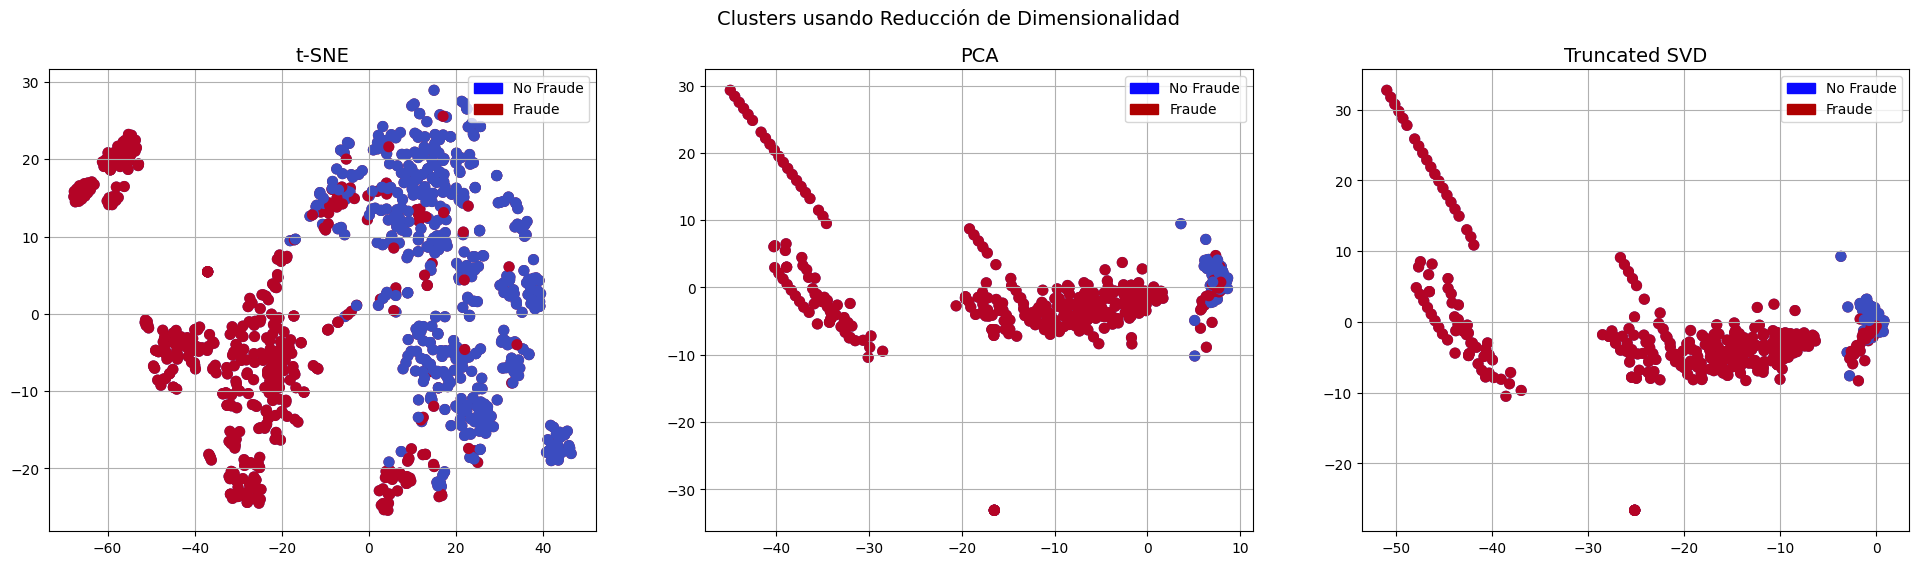

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# Título general
f.suptitle('Clusters usando Reducción de Dimensionalidad', fontsize=14)

# Leyendas de colores
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraude')
red_patch = mpatches.Patch(color='#AF0000', label='Fraude')

# Gráfico de dispersión t-SNE
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraude', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraude', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# Gráfico de dispersión PCA
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraude', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraude', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# Gráfico de dispersión Truncated SVD
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraude', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraude', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()


## Clasificadores (UnderSampling): ##

<a id="classifiers"></a>
En esta sección vamos a entrenar cuatro tipos de clasificadores y decidir cuál es más efectivo para detectar <b>transacciones fraudulentas</b>. Antes de eso, debemos dividir nuestros datos en conjuntos de entrenamiento y prueba, y separar las variables de las etiquetas.




In [21]:
from sklearn.model_selection import train_test_split
X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

sum(original_ytrain)/len(original_ytrain),sum(original_ytest)/len(original_ytest)


(0.001729245759178389, 0.0017204452090867595)

In [22]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Inicializamos el undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplicamos undersampling SOLO al conjunto de entrenamiento
Xtrain_resampled, ytrain_resampled = rus.fit_resample(original_Xtrain, original_ytrain)

# Verificamos la nueva distribución
print('Distribución original:', Counter(original_ytrain))
print('Distribución después de undersampling:', Counter(ytrain_resampled))


Distribución original: Counter({0: 227451, 1: 394})
Distribución después de undersampling: Counter({0: 394, 1: 394})


In [23]:
# Nuestros datos ya están escalados, así que ahora dividimos el conjunto en entrenamiento y prueba


# Esto se usa específicamente para el conjunto balanceado por submuestreo
X_train, X_test, y_train, y_test = train_test_split(Xtrain_resampled, ytrain_resampled, test_size=0.2, random_state=42)


In [24]:
# Convertimos los valores a arrays para poder alimentar a los algoritmos de clasificación
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [25]:
# Vamos a implementar clasificadores simples

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [26]:
# ¡Wow! Nuestros modelos están obteniendo puntajes altos incluso al aplicar validación cruzada.
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Clasificador:", classifier.__class__.__name__, "tiene un puntaje de entrenamiento de", round(training_score.mean(), 2) * 100, "% de accuracy")


Clasificador: LogisticRegression tiene un puntaje de entrenamiento de 92.0 % de accuracy
Clasificador: KNeighborsClassifier tiene un puntaje de entrenamiento de 93.0 % de accuracy
Clasificador: SVC tiene un puntaje de entrenamiento de 93.0 % de accuracy
Clasificador: DecisionTreeClassifier tiene un puntaje de entrenamiento de 90.0 % de accuracy


In [27]:
# Usamos GridSearchCV para encontrar los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# Obtenemos automáticamente la instancia de Logistic Regression con los mejores parámetros
log_reg = grid_log_reg.best_estimator_

# K-Nearest Neighbors
knears_params = {"n_neighbors": list(range(2, 5, 1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# Mejor estimador de K-Nearest Neighbors
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# Mejor estimador de SVC
svc = grid_svc.best_estimator_

# Decision Tree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2, 4, 1)),
               "min_samples_leaf": list(range(5, 7, 1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# Mejor estimador de árbol de decisión
tree_clf = grid_tree.best_estimator_


In [28]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.49%
Knears Neighbors Cross Validation Score 93.17%
Support Vector Classifier Cross Validation Score 93.49%
DecisionTree Classifier Cross Validation Score 92.38%


In [29]:
from sklearn.metrics import accuracy_score

# Predicciones sobre el conjunto de test
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

# Cálculo de accuracy
log_reg_acc = accuracy_score(y_test, y_pred_log_reg)
knear_acc = accuracy_score(y_test, y_pred_knear)
svc_acc = accuracy_score(y_test, y_pred_svc)
tree_acc = accuracy_score(y_test, y_pred_tree)

# Impresión con formato uniforme
print('Logistic Regression Test Accuracy: ', f'{round(log_reg_acc * 100, 2)}%')
print('K-Nearest Neighbors Test Accuracy: ', f'{round(knear_acc * 100, 2)}%')
print('Support Vector Classifier Test Accuracy: ', f'{round(svc_acc * 100, 2)}%')
print('Decision Tree Classifier Test Accuracy: ', f'{round(tree_acc * 100, 2)}%')


Logistic Regression Test Accuracy:  91.77%
K-Nearest Neighbors Test Accuracy:  93.67%
Support Vector Classifier Test Accuracy:  90.51%
Decision Tree Classifier Test Accuracy:  91.77%


In [30]:
from sklearn.metrics import accuracy_score

# Predicciones sobre el conjunto de test
y_pred_log_reg = log_reg.predict(original_Xtest)
y_pred_knear = knears_neighbors.predict(original_Xtest)
y_pred_svc = svc.predict(original_Xtest)
y_pred_tree = tree_clf.predict(original_Xtest)

# Cálculo de accuracy
log_reg_acc = accuracy_score(original_ytest, y_pred_log_reg)
knear_acc = accuracy_score(original_ytest, y_pred_knear)
svc_acc = accuracy_score(original_ytest, y_pred_svc)
tree_acc = accuracy_score(original_ytest, y_pred_tree)

# Impresión con formato uniforme
print('Logistic Regression Test Accuracy: ', f'{round(log_reg_acc * 100, 2)}%')
print('K-Nearest Neighbors Test Accuracy: ', f'{round(knear_acc * 100, 2)}%')
print('Support Vector Classifier Test Accuracy: ', f'{round(svc_acc * 100, 2)}%')
print('Decision Tree Classifier Test Accuracy: ', f'{round(tree_acc * 100, 2)}%')

Logistic Regression Test Accuracy:  97.06%
K-Nearest Neighbors Test Accuracy:  95.9%
Support Vector Classifier Test Accuracy:  98.31%
Decision Tree Classifier Test Accuracy:  94.09%


In [34]:
labels = ['No Fraude', 'Fraude']
smote_prediction = best_est.predict(original_Xtest)

# Mostramos el reporte de clasificación con etiquetas en español
print(classification_report(original_ytest, y_pred_log_reg, target_names=labels))

              precision    recall  f1-score   support

   No Fraude       1.00      0.97      0.99     56864
      Fraude       0.05      0.96      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.54     56962
weighted avg       1.00      0.97      0.98     56962



## Técnica SMOTE (Over-Sampling):
<a id="smote"></a>
<img src="https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png" width=800>
<b>SMOTE</b> significa *Synthetic Minority Over-sampling Technique*. A diferencia del *Random UnderSampling*, SMOTE crea nuevos puntos sintéticos para lograr un balance igual entre las clases. Esta es otra alternativa para resolver los problemas de desbalance de clases. <br><br>

<b> Entendiendo SMOTE: </b>
<ul>
<li><b>Resolver el desbalance de clases:</b> SMOTE crea puntos sintéticos de la clase minoritaria para lograr un equilibrio entre la clase minoritaria y la mayoritaria.</li>
<li><b>Ubicación de los puntos sintéticos:</b> SMOTE calcula la distancia entre los vecinos más cercanos de la clase minoritaria y, dentro de esas distancias, genera los nuevos puntos sintéticos.</li>
<li><b>Efecto final:</b> Se retiene más información ya que no se elimina ninguna fila, a diferencia del submuestreo aleatorio (random undersampling).</li>
<li><b>Compromiso entre precisión y tiempo:</b> Aunque SMOTE probablemente logre mayor *accuracy* que el submuestreo aleatorio, llevará más tiempo entrenar el modelo ya que no se reduce el tamaño del dataset.</li>
</ul>


## up--sampling: todos los datos para entrenamiento primero smoote luego separacion, ejemplos de up sampling, datos repetidos..la separacion despues de hacer el up sampling , ojo datos iguales.

In [35]:
from sklearn.model_selection import train_test_split
X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

sum(original_ytrain)/len(original_ytrain),sum(original_ytest)/len(original_ytest)

(0.001729245759178389, 0.0017204452090867595)

### probar smoote cuando las distribucones son distintas

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Definí los parámetros ANTES de usarlos
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Ahora sí creamos el RandomizedSearchCV
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

print('Tamaño de X (entrenamiento): {} | Tamaño de y (entrenamiento): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Tamaño de X (prueba): {} | Tamaño de y (prueba): {}'.format(len(original_Xtest), len(original_ytest)))

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority', random_state=42), rand_log_reg)
    model = pipeline.fit(original_Xtrain.iloc[train], original_ytrain.iloc[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain.iloc[test])

    accuracy_lst.append(pipeline.score(original_Xtrain.iloc[test], original_ytrain.iloc[test]))
    precision_lst.append(precision_score(original_ytrain.iloc[test], prediction))
    recall_lst.append(recall_score(original_ytrain.iloc[test], prediction))
    f1_lst.append(f1_score(original_ytrain.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain.iloc[test], prediction))

print('---' * 45)
print('')
print("Accuracy promedio: {}".format(np.mean(accuracy_lst)))
print("Precision promedio: {}".format(np.mean(precision_lst)))
print("Recall promedio: {}".format(np.mean(recall_lst)))
print("F1 Score promedio: {}".format(np.mean(f1_lst)))
print('---' * 45)


Tamaño de X (entrenamiento): 227845 | Tamaño de y (entrenamiento): 227845
Tamaño de X (prueba): 56962 | Tamaño de y (prueba): 56962
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy promedio: 0.9739954793829139
Precision promedio: 0.05563379986479587
Recall promedio: 0.8759493670886075
F1 Score promedio: 0.1046139455903901
---------------------------------------------------------------------------------------------------------------------------------------


In [37]:
y_score = best_est.decision_function(original_Xtest)

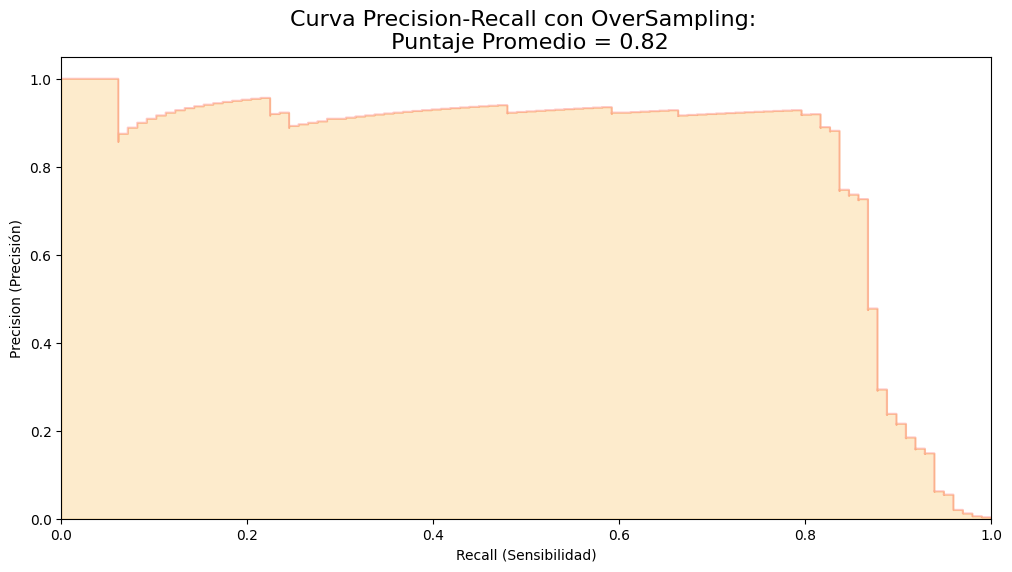

In [40]:
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score # Import precision_recall_curve and average_precision_score
import numpy as np # Already imported, but good to ensure

# ... (rest of your code)

fig = plt.figure(figsize=(12,6))

precision, recall, thresholds = precision_recall_curve(original_ytest, y_score)

# Calculate average precision
average_precision = average_precision_score(original_ytest, y_score) # Calculate average precision

# Curva Precision-Recall con técnica de OverSampling (SMOTE)
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision (Precisión)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curva Precision-Recall con OverSampling: \n Puntaje Promedio = {0:0.2f}'.format(
          average_precision), fontsize=16)

plt.show() # Add this to display the plot

Text(0.5, 1.0, 'Curva Precision-Recall con OverSampling: \n Puntaje Promedio = 0.82')

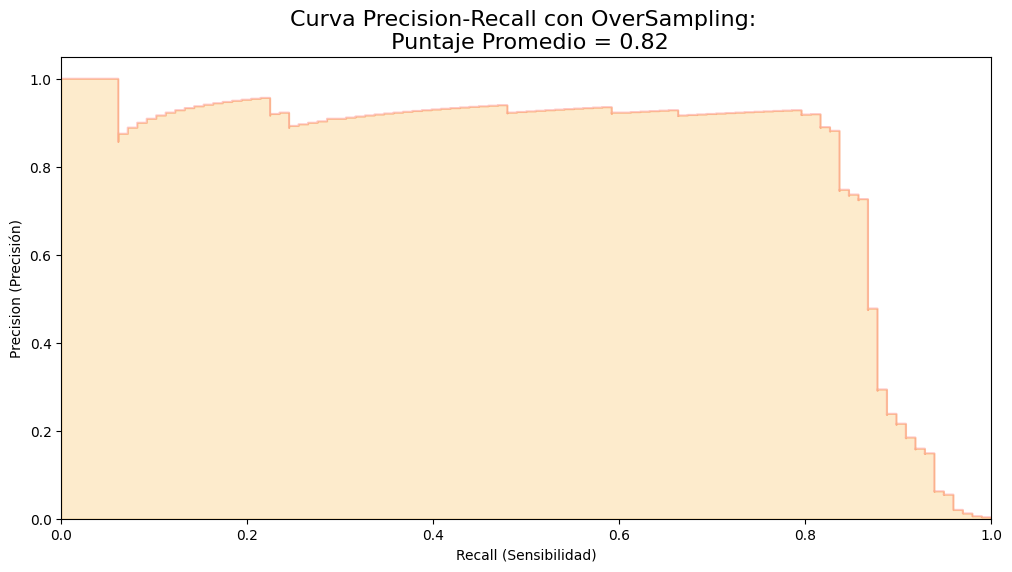

In [41]:
fig = plt.figure(figsize=(12,6))

precision, recall, thresholds = precision_recall_curve(original_ytest, y_score)

# Curva Precision-Recall con técnica de OverSampling (SMOTE)
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision (Precisión)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curva Precision-Recall con OverSampling: \n Puntaje Promedio = {0:0.2f}'.format(
          average_precision), fontsize=16)


In [42]:
from sklearn.metrics import f1_score
import numpy as np

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Umbral óptimo según F1:", best_threshold)


Umbral óptimo según F1: 13.393492966895955


In [43]:
labels = ['No Fraude', 'Fraude']
y_score = best_est.decision_function(original_Xtest)
smote_prediction_custom = (y_score >= best_threshold).astype(int)

# Mostramos el reporte de clasificación con etiquetas en español
print(classification_report(original_ytest, smote_prediction_custom, target_names=labels))

              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     56864
      Fraude       0.92      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [44]:
y_score = best_est.decision_function(original_Xtest)

Text(0.5, 1.0, 'Curva Precision-Recall con OverSampling: \n Puntaje Promedio = 0.82')

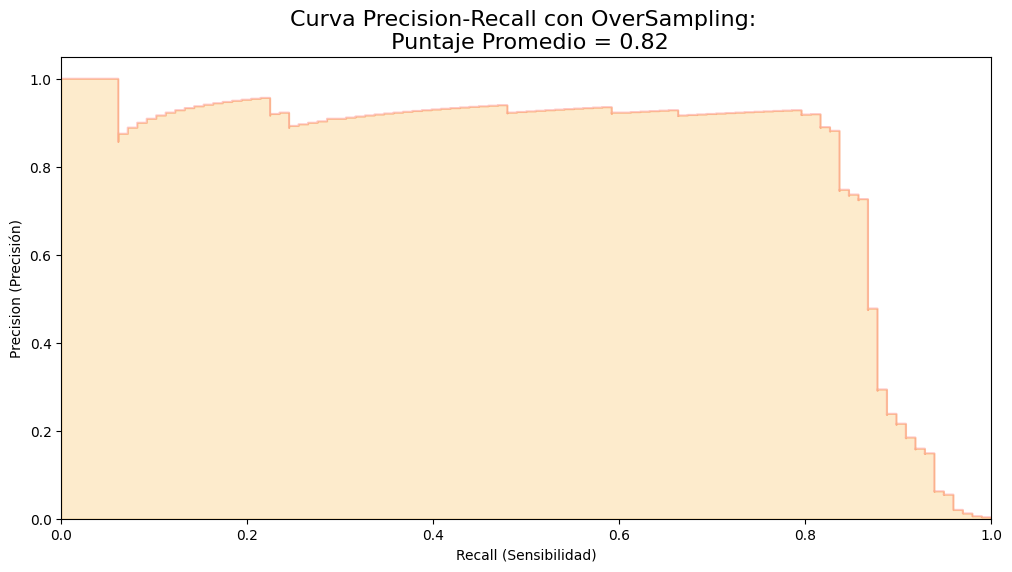

In [45]:
fig = plt.figure(figsize=(12,6))

precision, recall, thresholds = precision_recall_curve(original_ytest, y_score)

# Curva Precision-Recall con técnica de OverSampling (SMOTE)
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision (Precisión)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curva Precision-Recall con OverSampling: \n Puntaje Promedio = {0:0.2f}'.format(
          average_precision), fontsize=16)

In [47]:
thresholds

array([-65.38460074, -52.87252403, -46.929163  , ...,  76.96452287,
        83.25817497,  84.21041892])

In [46]:
from sklearn.metrics import f1_score
import numpy as np

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Umbral óptimo según F1:", best_threshold)

Umbral óptimo según F1: 13.393492966895955


In [48]:
labels = ['No Fraude', 'Fraude']
y_score = best_est.decision_function(original_Xtest)
smote_prediction_custom = (y_score >= best_threshold).astype(int)

# Mostramos el reporte de clasificación con etiquetas en español
print(classification_report(original_ytest, smote_prediction_custom, target_names=labels))

              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     56864
      Fraude       0.92      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

